In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import jqdatasdk as jq
import os

# 请在环境变量中设置聚宽账号。账号可在jointquant.com上免费申请
account = os.environ.get('JQ_ACCOUNT')
password = os.environ.get('JQ_PASSWORD')

account='18694978299'
password = '87Ai2y3LzPOe'

jq.auth(account, password)

提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改
auth success 


经过前面两章的学习，你现在已经基本拥有了一个常规股票软件所具有的能力！从这一章起，我们通过一些例子来看看如何解锁这些能力。这一章我们将考察一些均线战法的例子。

# 均线的计算

均线的作用是用来平滑股价的波动。一个充满了太多突变和断点的系统是无法分析的。在上一章里我们讲到计算分时均线的两种方法：

- 对个股，我们使用了其到当前时刻的累积成交额、除于其到当前时刻的累积成交量，这样就得到了从开盘以来，到当前时刻的平均成交价。

    _np.cumsum(money)/np.cumsum(volume)_
    
    这里money、volume都是np.array数组（通过get_bars获得），对它们进行np.cumsum之后，仍然是一个np.array数组；此外两个同维度的np.array数组进行四则运算，得到的结果仍然是与输入相同维度的np.array数组。这是numpy运算的广播特性。当我们运用这个特性来进行大规模的数学运算时，可以得到很好的性能。

- 对指数，由于指数编制方法不同，上数方法不能奏效。因此我们使用了从开盘以来，直到现在所有价格的平均值。这也是同花顺分时均价线的一个算法。
   _np.cumsum(close)/np.count_nonzero(close > 0)_
   
   这里close是每分钟收盘价，仍然是一个numpy数组。np.cumsum(close)是求从开盘以来，到每一个元素所在的位置的收盘价的累加。np.count_nonzero(close > 0)实际上是要计算对应被累加的收盘价个数。
   
在K线图中，我们使用另一种方式来计算均线，即使用移动平均(moving average,简称ma)。与上述方法中，总是使用从开盘以来、到当前为止的所有收盘价代入计算不同，我们在计算ma值时，只使用滑动窗口以内的那些收盘价，因为过早的数据，可能对当下并没有太多意义。

我们仍然使用numpy来计算ma的值。注意，在上一章我们通过get_bars来获取行情数据时，我们推荐改写参数df=False，以返回numpy structured array数据结构的数据。反之，返回的行情数据是pandas.DataFrame的。

这里我们要接触一个科学函数，convolve，即卷积。

In [4]:
def moving_average(ts, win):
    return np.convolve(ts, np.ones(win)/win, 'valid')

这里我们使用了长度为win，每个元素为1/win的卷积核。当我们有其它信号平滑处理要求时，我们可能使用别的卷积核，比如高斯核：

    gaussian_kernel_3 = np.array([0.25, 0.5, 0.25])
    gaussian_kernel_5 = np.array([0.0625, 0.25, 0.375, 0.25, 0.0625])
    gaussian_kernel_7 = np.array([0.03125, 0.109375, 0.21875, 0.28125, 0.21875, 0.109375, 0.03125])

现在我们来尝试求一个日线的ma5:

[3242.83 3232.84 3220.51 3230.29 3258.1  3286.54 3309.83]


Text(0, 3280, '000001 2020/10/14')

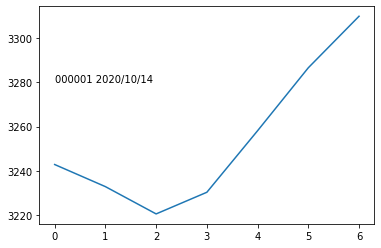

In [10]:
shbars = jq.get_bars('000001.XSHG', 11, '1d', include_now=True, df=False)
ma5 = moving_average(shbars['close'], 5)
print(np.round(ma5, 2))
plt.plot(ma5)
plt.text(0,3280, '000001 2020/10/14')

与行情软件对照，结果一模一样。使用np.convovle的优势在于其速度。假设我们现在要对全市场所有的股票求日线的ma5，这需要多少时间呢？有人曾经使用过talib,因为需要进行循环，所以最后需要好几分钟才能算出来。我们来试一下：

In [58]:
# 模拟4000支股票的收盘价数据
n = 4000
ts = np.repeat(shbars['close'],n)

# 现在我们得到一个 4000*11的二维数组
ts = np.transpose(np.reshape(ts, (-1,n)))

# 使用np.convole来计算，它只能处理一维数组
%timeit np.convolve(np.ravel(ts), np.ones(5)/5, 'valid')

147 µs ± 3.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


上面的代码中由于我们只关心计算速度，所以我们通过repeat，把已拿到的上证指数的收盘价重复了4000遍，这相当于获取了全市场的收盘价。然后我们直接对这个新的数组（一个有44000维的巨大数组）求移动均值，结果发现，只共只需要89us（使用的2015年的curo i7)。

当然，上面的代码只是为了演示如何进行性能优化，这样计算出来的结果，还必须进行后处理才能使用，因为它把前后相连的两支股票会放在一起计算均值。这里我们使用性能上略慢一点的scipy中的函数：

In [59]:
# 使用scipy来计算
from scipy import signal
ma5 = signal.convolve2d(ts, [np.ones(5)/5], 'valid')
print(np.round(ma5[1],2))
%timeit signal.convolve2d(ts, [np.ones(5)/5], 'valid')

[3242.83 3232.84 3220.51 3230.29 3258.1  3286.54 3309.83]
645 µs ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


将结果进行对照，计算完全正确。对4000支股票计算5日均线值，只花了645us。

**在代码中我们注意了性能优化，这样就带来了一定的阅读难度，但为了贴近实战，后面大家会发现，实战中对性能要求还是很高的**

# 求直线的斜率

如果你用过通达信软件的公式，就知道它提供了一个名为slope的函数。不过因为帮助文档不够清楚的关系，我一直不知道这个函数应该怎么用。比如，看上去是斜率公式，那它的单位是什么？倾角？还是一次性系数？

但是，相关的概率在短线中还是很有用的。比如，如果一支大涨后的股票进入盘整阶段，当前已接近某均线；此时是否可以买入呢？如果均线有较好的支撑作用，很可能该股马上转入主升；如果均线支撑力度不强，则有可能还会继续下跌。

判断均线支撑力度强弱的标准是什么？这里我们给一个斜率因子。如果均线的斜率越大，则支撑越强。

如果均线在K线图上显示为一条近似直线的话，那么就可以使用一次项拟合来求得其斜率。

In [138]:
def rmse(y, y_hat):
    """
    返回预测序列相对于真值序列的标准差。
    Args:
        y:
        y_hat:

    Returns:

    """
    return np.sqrt(np.mean(np.square(y - y_hat)))

def slope(ts, err):
    """返回直线斜率和倾角。如果拟合误差大于err，则抛出异常
    """
    # 对ts进行归一化，以便斜率可以在不同的时间序列之间进行比较
    assert ts[0] != 0
    ts = ts / ts[0]
    x = np.arange(len(ts))
    z = np.polyfit(x, ts, deg=1)
    p = np.poly1d(z)
    
    ts_hat = np.array([p(xi) for xi in x])
    error = rmse(ts, ts_hat) / np.sqrt(np.mean(np.square(ts)))
    if error >= err:
        raise ValueError("can not fit into line")
        
    return z[0]

# 现在看看今天（2020年10月14日，上证指最近5天MA的斜率
ma5 = moving_average(shbars['close'], 5)[2:]
a = slope(ma5, 0.1)
print(f"{a:.2%}")

0.73%


得到的斜率是0.73%。这里的斜率意味着每过1天，大盘MA5上涨0.73%，也就是20多个点。这也说明大盘最近相当强势，在过去一年里，有多少天是这样的呢？留给大家作为习题吧，评论区给解答。
当然，如果斜率函数能给出均线与横轴的夹角，那就更直观了。然而，这里有一个误区。均线与横轴的夹角，不光取决于均线走势本身，还取决于我们如何绘制均线。在后面的深度学习章节里，我们会把这些数据图形化，再通过CNN网络来学习，那时候我们再详细讨论这种误区。

# 均线策略1 - 均线多头排列

假设我们要找出近期刚出现均线多头的股。为了便于演示，我们就找5，10，20均线多头的好了。

In [117]:
def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths
    
def is_long_parallel(ts, n):
    """
    :param ts: 收盘价数组
    :params n: 多头排列刚形成n天
    """
    
    ma5 = moving_average(ts, 5)
    ma10 = moving_average(ts, 10)
    ma20 = moving_average(ts, 20)
    
    # 注意各均线序列的长度并不一样
    ma5 = ma5[-10:]
    ma10 = ma10[-10:]
    ma20 = ma20[-10:]
    
    signal = (ma5>ma10) &(ma10>ma20)
    
    run_values, run_starts, run_lengths = find_runs(signal)
    
    # 最后一段必须为多头排列，且长度为要求的n
    return run_values[-1] == True and run_lengths[-1] == n
    
# 我们以上证2020年6月24为例，看是否形成了均线多头（且刚形成两天）
bars = jq.get_bars('000001.XSHG', 30, '1d', end_dt='2020-6-24',include_now=True)
ts = bars['close']

is_long_parallel(ts, 2)

True

大家知道，A股在6月底、7月初形成一股主升浪。如果我们早就知道这个方法，并且始终在用程序监控的话，是否也能抓住今年这最大的一波行情呢？

# 均线策略 - 月线回踩

![](http://images.jieyu.ai/images/2020-10/20201014202805.png)

我们看到月均线呈直线上升之势，而且在7月、8月、9月都回踩过均线。如果在回踩均线时介入，真是进可攻、退可守的好棋。现在，我们就使用均线多头加斜率参数来找出这种股。

上面图形中的这只个股，它的月线斜率是0.069，也就是月线的ma5每个月上涨6.9%，这是一个相当好的涨幅，因为这是均线的上涨，实际股价的上涨要比这个高一些，但也还没有到最后的主升浪的疯狂期。在下面的函数中，我们将月线斜率设置为0.04，以便筛选出处在上涨早期的个股。

In [ ]:
securities = jq.get_all_securities()
def find_adv_maline(end:str, slp=0.04):
    import arrow
    _end = arrow.get(end)
    for code in securities.index:
        if securities.loc[code]['end_date'].date()<arrow.get(end).date():
            continue
            
        bars = jq.get_bars(code, 9, '1M', end_dt=end, include_now=True, df=False,fq_ref_date=end)
        if len(bars) < 9:
            continue
            
        all_up = np.all(bars['close'][-3:]>bars['open'][-3:])
        ma = moving_average(bars['close'],5)
        try:
            if slope(ma, 0.1) >= slp and all_up:
                print(code, securities.loc[code]['display_name'])
        except Exception:
            pass
            
find_adv_maline('2020-10-1')

共产生了110个左右的信号，我在这里选取了16个：
![](http://images.jieyu.ai/images/2020-10/20201014214244.png)
16朵妖艳的玫瑰。我爱她们。她们有的含羞待放，有的艳不可挡，有的丰韵犹存，在大盘的呵护下，或许还能摇曳生姿直到这个深秋。

这些股票最好的买入点，是等它回到5月均线的那一天。也许你没有耐心每天对着100多支股票去检查有没有到5月均线，没关系，我们即将推出一个智能监控工具，现在提供首批25名免费名额。

# 结束语
好了。这一章的主要内容就到这里。你或许已经注意到，我们没有提及任何经典的指标，比如macd,kdj,rsi,bolling band,wm等等。那是因为，这些指标属于历史，也不属于这里的股市。在序言那一章里，我们已或多或少谈起过这个话题。但是，如果你特别好奇的话，你可以使用talib库。这是一个c++的库，有python的接口，它提供了几乎所有经典指标的计算。


即使只以我们现在介绍的内容，就足以发现打开财富大门的钥匙，如果你对照本文反复练习，你会相信这一点。当然，这里还存在一些交易技巧和看盘技巧没有讲，需要你自己去琢磨。随着我们进入到机器学习和深度学习的部分，你会掌握更加高级、丰富和稳健的策略，或者说没有固定的策略，机器生成一切。

为了第一时间得到这些文章，请关注本号。本教程的目录在底部菜单的 **AI量化交易** 菜单栏下。